## ================================================================
## BRIAN2 SIMULATION OF A RECURRENT EXCITATORY NEURONAL NETWORK
## ================================================================
This notebook simulates current-driven excitatory neurons without
spike-frequency adaptation (**AHP**).
The outputs are used to generate panels for Supplementary Figures S2.

In [ ]:
# ------------------------------------------------
# Import required packages
# ------------------------------------------------

!pip install brian2 -q
# !pip install pyparsing==3.0.9 sympy==1.12
from brian2 import *
import numpy as np
from time import time
set_device('cpp_standalone', build_on_run=False)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.2 MB/s eta 0:00:00


In [ ]:
# ================================================================
# Parameter Setting
# ================================================================
# Define biophysical, synaptic, and network parameters.
# These include Nernst potentials, conductances, time constants,
# network geometry, and noise amplitude.

Ne = 100                            # Number of excitatory neurons
El = -39.2 * mV                     # Nernst potential of leaky ions
EK = -80 * mV                       # Nernst potential of potassium
ENa = 70 * mV                       # Nernst potential of sodium
VT = -30.4*mV                       # alters firing threshold of neurons
E_ampa = 0*mV                       # reverse synaptic potential
g_ampa = 0.35*nS                    # conductance increment when spike on pre
tau_ampa = 2*ms                     # synaptic time constant AMPA
E_nmda = 0 * mV                     # Nernst potential of synaptic channels
taud_nmda = 100 * ms                # decay time constant of nmda conductance
taur_nmda = 2 * ms                  # rise time constant of nmda conductance
tau_d = 800 * ms                    # Recovery time constant of synaptic vesicles
grid_dist = 45 * umeter
Vmax = 25*mm/second                 # Axonal conduction velocity
fD = 0.1                            # Synaptic depression strength
g_nmda = 0.01*nS
sigma = 0*mV
I_dc = np.linspace(8.77_895, 8.77_905, 12)*pA

# ================================================================
# Definition of Cell Intrinsic and Synaptic Equations
# ================================================================
# Hodgkin–Huxley-like intrinsic dynamics with leak, Na+, and K+ currents.
# Includes AMPA and NMDA synaptic currents.

eqs = '''
dV/dt = (noise -gl*(V-El) - g_na*(m**3)*h*(V-ENa) - g_kd*(n**4)*(V-EK) - I_syn + I)/Cm : volt
dm/dt = alpha_m*(1-m)-beta_m*m : 1
dh/dt = alpha_h*(1-h)-beta_h*h : 1
dn/dt = alpha_n*(1-n)-beta_n*n : 1
alpha_m = 0.32*(mV**-1)*4*mV/exprel((13*mV-V+VT)/(4*mV))/ms : Hz
beta_m = 0.28*(mV**-1)*5*mV/exprel((V-VT-40*mV)/(5*mV))/ms : Hz
alpha_h = 0.128*exp((17*mV-V+VT)/(18*mV))/ms : Hz
beta_h = 4./(1+exp((40*mV-V+VT)/(5*mV)))/ms : Hz
alpha_n = 0.032*(mV**-1)*5*mV/exprel((15*mV-V+VT)/(5*mV))/ms : Hz
beta_n = .5*exp((10*mV-V+VT)/(40*mV))/ms : Hz
noise = sigma*(2*gl*Cm)**.5*randn()/sqrt(dt) : amp (constant over dt)
I_syn = I_ampa+I_nmda : amp
I_ampa = g_ampa*(V-E_ampa)*s_ampa : amp
ds_ampa/dt = -s_ampa/tau_ampa : 1
I_nmda = g_nmda*(V-E_nmda)*s_nmda_tot/(1+exp(-0.062*V/mV)/3.57) : amp
s_nmda_tot : 1
x : meter
y : meter
area : meter**2
Cm = (1*uF*cm**-2) * area : farad
g_na = (50*mS*cm**-2) * area : siemens
g_kd = (5*mS*cm**-2) * area : siemens
gl = (0.3*mS*cm**-2) * area : siemens
I : amp
'''

eqs_synE_model = '''
s_nmda_tot_post = w * s_nmda * x_d : 1 (summed)
ds_nmda/dt = -s_nmda/(taud_nmda)+x_nmda*(1-s_nmda)/taur_nmda : 1 (clock-driven)
dx_nmda/dt = -x_nmda/(taur_nmda) : 1 (clock-driven)
dx_d/dt = (1-x_d)/tau_d :1 (clock-driven)
w : 1
'''

eqs_synE_onpre = '''
s_ampa += w * x_d
x_nmda += 1
x_d *= (1-fD)
'''


# ================================================================
# Network Construction
# ================================================================
# Define neuron group, spatial layout, and synaptic connectivity.

cellsExc = NeuronGroup(Ne, model=eqs, threshold='V>0*mV', refractory=2*ms, method='exponential_euler')
# areas = [np.random.uniform(low=170, high=270)*um**2 if x % 20 != 0 else 300*um**2 for x in range(100)]
cellsExc.area = 220*um**2  # areas
cellsExc.V = El

# Spatial distribution
cellsExc.x = '(i % int(sqrt(Ne))) * grid_dist'
cellsExc.y = '(i // int(sqrt(Ne))) * grid_dist'

# Load predefined structural connectivity (source/target pairs)
sources = np.load('source_SF_RND_a2.npy')   # to change accordingly
targets = np.load('target_SF_RND_a2.npy')   # to change accordingly

# Create excitatory synapses
syn_EE = Synapses(cellsExc, cellsExc, model=eqs_synE_model, on_pre=eqs_synE_onpre, method='euler')
syn_EE.connect(i=sources, j=targets)
syn_EE.w = cellsExc.area[targets]/(300*um**2)

# Distance-dependent synaptic delays
syn_EE.delay = '(sqrt((x_pre - x_post)**2 + (y_pre - y_post)**2))/Vmax'


# ================================================================
# Simulation Execution and Spike Train saving
# ================================================================
# Run the simulation for a specified duration and record spike times.

spikes = SpikeMonitor(cellsExc)

dur = 65*second
run(dur)
device.build(run=False)

results = []
for idx, idc in enumerate(I_dc[5:7]):
    device.run(run_args={cellsExc.I: idc})
    sp_t = spikes.t[spikes.t > 5*second]-5*second
    sp_i = spikes.i[spikes.t > 5*second]
    results.append((sp_t, sp_i))
    print(f'Finished Iteration {idx+1}')

Finished Iteration 1
Finished Iteration 2


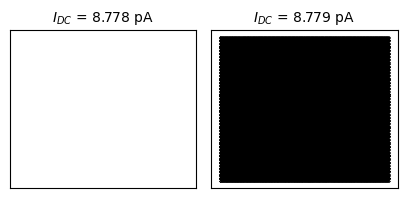

In [ ]:
# ================================================================
# Visualization and Saving
# ================================================================
# Generate raster plots showing the spiking activity of neurons
# for each tested IDC value. Each subplot corresponds to one
# simulation condition.

fig, axes = subplots(1, 2, figsize=(10.61/2.54, 5.3/2.54))

I_dc = [8.778, 8.779]

for ax, sp, idc in zip(axes.flat, results, I_dc):
  ax.set_title(fr'$I_{{DC}}$ = {idc} pA', fontsize=10)
  ax.scatter(sp[0], sp[1], s=0.003, color='k')
  ax.set_xticks(ticks=[], labels=[])
  ax.set_yticks(ticks=[], labels=[])

fig.tight_layout()
fig.savefig('Raster_current_driven_no_ahp_v2.tif', dpi=600)